In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This notebook shows how to construct the number of excess deaths (relative to a counterfactual 2020) from ISTAT data on total deaths. It then compares these excess deaths to the counterfactual including Covid-19 deaths.

- The source for the ISTAT data is: https://www.istat.it/it/archivio/240401 $\to$ "Decessi del 2020" $\to$ "Dataset analitico con i decessi giornalieri". 

- The source for the official Covid-19 deaths is https://github.com/pcm-dpc/COVID-19

# 1) Processing the ISTAT data

In [2]:
df = pd.read_csv('./ISTAT_data/dati-comunali-giornalieri-1/comune_giorno.zip',
                 encoding = "ISO-8859-1")
df = df[['COD_PROVCOM', 'GE'] + ['TOTALE_{}'.format(yr) for yr in range(15,21)]] \
        [df.TOTALE_20 < 9999].reset_index(drop=True).copy(deep=True)

verify that we have the correct number of municipalities

In [3]:
print(len(list(set(df.COD_PROVCOM))))
del df['COD_PROVCOM']

1689


compute total deaths for each date across all municipalities for each year

In [4]:
df = df.groupby('GE').sum()
df.reset_index(inplace=True)

dropping all dates before February 23rd (the first official Covid death is recorded on Feb 24th)

In [5]:
df = df[df.GE >= 223]

replacing Feb 29th with 2016 value for 2015-2019

In [6]:
print(df.loc[df.GE==229,'TOTALE_16'].values[0])
df = df.replace(0, 555)

555


computing cumulative totals

In [7]:
df = df.sort_values(by='GE').reset_index(drop=True).copy(deep=True)
for i in range(15, 21):
    df['cs_{}'.format(i)] = df['TOTALE_{}'.format(i)].cumsum()
    del df['TOTALE_{}'.format(i)]

computing daily growth rates for 2015-2019

In [8]:
for yr in range(15, 20):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

computing average of daily growth rates 15-19

In [9]:
df['daily_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(15,20)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(15,20)], axis=1)

extrapolating forward

In [10]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.GE==223,'cs_20'].values[0]

In [11]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [12]:
df = df.drop(['daily_growth'], axis=1)

creating a date column

In [13]:
df.columns = ['GE', '2020', 'counterfactual_2020']
df['month'] = df['GE'].astype('str').str[:1].astype('int')
df['day'] = ('0'+df['GE'].astype('str').str[1:]).str[-2:]
df['date'] = '2020-0' + df.month.astype('str') + '-' + df.day.astype('str')
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')
df = df[['date', '2020', 'counterfactual_2020']].copy(deep=True)

# 2) Processing the official covid data from protezione civile

In [14]:
official = pd.read_csv('./COVID_protezione_civile_data/dati-regioni/dpc-covid19-ita-regioni.csv')[['data', 'deceduti']]

In [15]:
official['aux'] = official['data'].astype('str').str[:10]
official['date'] = pd.to_datetime(official['aux'] , format='%Y%m%d', errors='ignore')
official = official[['deceduti', 'date']]
official = official.groupby('date').sum()
official.reset_index(inplace=True)

# 3) Merging and plotting

In [16]:
df = pd.merge(df, official, on=['date'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual_2020 + df.deceduti
del df['deceduti']

In [17]:
df.index=df.date
del df['date']

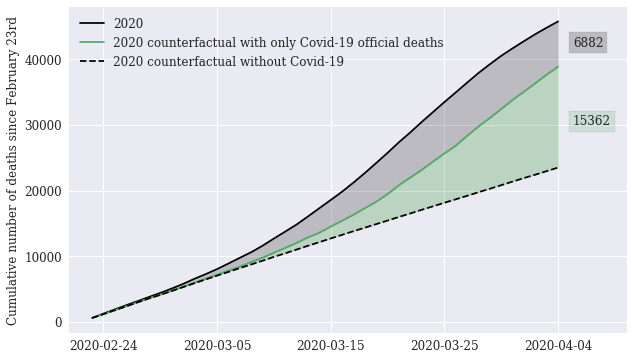

In [18]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual_2020'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(df.index[[1,11,21,31,41]])
ax.fill_between(df.index, df['2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual_2020'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since February 23rd',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 4

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(42.3, 30000, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(42.3, 42000, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_italy.pdf', bbox_inches='tight', dpi=100)

In [19]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 15362.0 = green - dashed black
Excess deaths: 22244.0 = solid black - dashed black
Unexplained excess deaths: 6882.0 = solid black - green
